# USAD

## Environment

In [1]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [2]:
# !git clone https://github.com/manigalati/usad

In [2]:
%cd /usr/local/data/elisejzh/Projects/Anomaly_Detection/usad/

/usr/local/data/elisejzh/Projects/Anomaly_Detection/usad


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [4]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-b7283323-3998-2b76-97e2-3017160af059)


## EDA - Data Pre-Processing

In [5]:
down_rate=5

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

mkdir: cannot create directory ‘input’: File exists
input/SWaT_Dataset_Normal_v1.csv [Exists]
input/SWaT_Dataset_Attack_v0.csv [Exists]


### Normal period

In [7]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/data/elisejzh/anaconda3/envs/USAD/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [8]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [9]:
#Downsampling
normal=normal.groupby(np.arange(len(normal.index)) // down_rate).mean()
normal.shape

(99000, 51)

#### Normalization

In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

# x = normal.values
# x_max=np.nanmax(x) 
# x_min=np.nanmin(x)
# x_std = (x - x_min)/(x_max - x_min)
# normal = pd.DataFrame(x_std)

In [11]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005241,0.5,0.0,0.0,0.008695,0.075126,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.003821,0.5,0.0,0.0,0.008695,0.074071,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [12]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/usr/local/data/elisejzh/anaconda3/envs/USAD/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(449919, 51)

In [ ]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [14]:
#Downsampling the attack data
attack=attack.groupby(np.arange(len(attack.index)) // down_rate).mean()
attack.shape

(89984, 26)

In [15]:
#Downsampling the labels
labels_down=[]

for i in range(len(labels)//down_rate):
    if labels[5*i:5*(i+1)].count(1.0):
        labels_down.append(1.0) #Attack
    else:
        labels_down.append(0.0) #Normal

#for the last few labels that are not within a full-length window
if labels[down_rate*(i+1):].count(1.0):
    labels_down.append(1.0) #Attack
else:
    labels_down.append(0.0) #Normal

print(len(labels_down))

89984


#### Normalization

In [17]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

# x = attack.values 
# x_std = (x - x_min)/(x_max - x_min)
# attack = pd.DataFrame(x_std)

In [18]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Windows

In [19]:
window_size=12

In [20]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(98988, 12, 26)

In [21]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(89972, 12, 26)

## Training

In [22]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 70
hidden_size = 40

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [328]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0854, val_loss2: 0.0822
Epoch [1], val_loss1: 0.0426, val_loss2: -0.0005
Epoch [2], val_loss1: 0.0428, val_loss2: -0.0147
Epoch [3], val_loss1: 0.0419, val_loss2: -0.0213
Epoch [4], val_loss1: 0.0413, val_loss2: -0.0251
Epoch [5], val_loss1: 0.0409, val_loss2: -0.0275
Epoch [6], val_loss1: 0.0418, val_loss2: -0.0303
Epoch [7], val_loss1: 0.0409, val_loss2: -0.0310
Epoch [8], val_loss1: 0.0411, val_loss2: -0.0322
Epoch [9], val_loss1: 0.0411, val_loss2: -0.0331
Epoch [10], val_loss1: 0.0410, val_loss2: -0.0338
Epoch [11], val_loss1: 0.0412, val_loss2: -0.0346
Epoch [12], val_loss1: 0.0415, val_loss2: -0.0354
Epoch [13], val_loss1: 0.0425, val_loss2: -0.0368
Epoch [14], val_loss1: 0.0425, val_loss2: -0.0372
Epoch [15], val_loss1: 0.0430, val_loss2: -0.0380
Epoch [16], val_loss1: 0.0431, val_loss2: -0.0383
Epoch [17], val_loss1: 0.0420, val_loss2: -0.0375
Epoch [18], val_loss1: 0.0416, val_loss2: -0.0374
Epoch [19], val_loss1: 0.0422, val_loss2: -0.0382
Epoch [20],

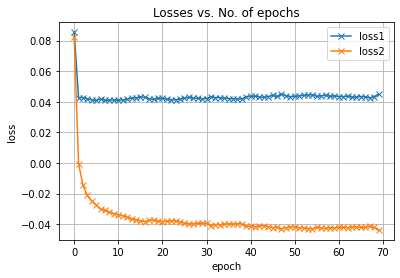

In [329]:
plot_history(history,'SWaT')

In [330]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model_SWaT.pth")

#### Another way to save the model!

In [24]:
import pickle

In [29]:
filename = 'usad_model_SWaT.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model
filename = 'usad_model_SWaT.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Testing

In [27]:
checkpoint = torch.load("model_SWaT.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
training_scores_list=training_scores(model,train_loader,val_loader)

In [31]:
training_scores_concat=np.concatenate([torch.stack(training_scores_list[:-1]).flatten().detach().cpu().numpy(),
                            training_scores_list[-1].flatten().detach().cpu().numpy()])

In [43]:
print(training_scores_concat)

[0.27874607 0.27874607 0.27874607 ... 0.00468598 0.00468598 0.00468598]


In [42]:
min(training_scores_concat)

0.004543449

In [ ]:
results=training_scores(model, test_loader) # testing

In [ ]:
print(results)

In [23]:
windows_labels=[]
for i in range(len(labels_down)-window_size):
    windows_labels.append(list(np.int_(labels_down[i:i+window_size])))

In [24]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels] # this is with the point adjust?

In [25]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                            results[-1].flatten().detach().cpu().numpy()])

In [30]:
results_threshold=testing_threshold(model,test_loader,alpha=.5, beta=.5, contamination=0.10)

In [31]:
results_threshold

0.15603226

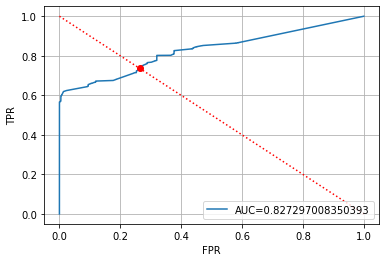

array([0.08922771], dtype=float32)

In [39]:
threshold=ROC(y_test,y_pred)
threshold

In [32]:
threshold=results_threshold # Decide on your own threshold
y_pred_label = [1.0 if (score > threshold) else 0 for score in y_pred ]

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
prec=precision_score(y_test,y_pred_label,pos_label=1)
recall=recall_score(y_test,y_pred_label,pos_label=1)
f1=f1_score(y_test,y_pred_label,pos_label=1)
print('precision=',prec)
print('recall=',recall)
print('f1=',f1)


precision= 0.7955005624296962
recall= 0.6240734204024003
f1= 0.6994362575412917
